#Projeto 1 - ADNE
##Tensorflow, Keras Sequencial e Keras Funcional

# Introdução
Neste trabalho de ADNE terei como objetivo demonstrar o bom uso do Tensorflow sem APIs mais high level (operações simples e low level do **Tensorflow default** (*vanilla*)) e de seguida com a API do Keras ambas a versão **sequencial** e **funcional** para construir redes neuronais. Na variante **sequencial**, o modelo é definido layer a layer sem extras nem branchings. Na **funcional** temos mais flexibilidade por já podemos ter os ditos branches que nos permitem ter vários outputs por exemplo, como é o caso da imagem abaixo. 
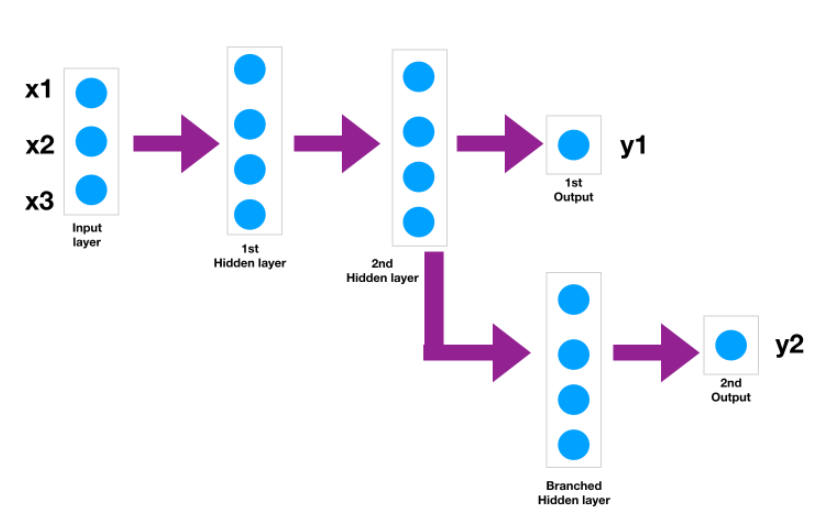

Source: https://www.analyticsvidhya.com/blog/2021/07/understanding-sequential-vs-functional-api-in-keras/

## Tensorflow Vanilla

O tensorflow permite definir computações que são definidas por um **grafo**. Nestes grafos de computação, cada **nó representa uma operação** e cada **arco representa um tensor** que no fundo é uma matriz.

## Preparação dos dados
Relativamente ao modelo a realizar, este terá como objetivo prever a força do cimento tendo em conta os atributos relativos à constituição do mesmo logo é um **problema de regressão** (tal será importante para decisões a tomar na configuração da rede mais à frente). Importante de referir que devemos fazer a standardização de todos os dados para prevenir problemas de instabilidades numéricas e colocarmos tudo na mesma escala como já faziamos para aprendizagem automática (**standardização**) e que, por ser um problema de regressão, a coluna com o valor objetivo também pode ser standardizada por não representar classes.

Com o conjunto de dados que temos, primeiro fazemos o *shuffling* por não saber a ordem com que foram escritos para o ficheiro (podem estar por exemplo por ordem crescente e nós queremos que estejam completamente em bruto e misturados), separamos em **dois conjuntos independentes**. Um deles será o conjunto de **treino** que servirá para treinar o modelo e o outro, de **validação**, que nunca será observado pelo nosso modelo e que será usado no final para testar a performance do nosso modelo. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf

#Standardização
data = pd.read_csv('concrete.csv')  
data = shuffle(data)
data = data.to_numpy()
means = np.mean(data,axis=0)
stds = np.std(data,axis=0)
data = (data-means)/stds

#Conjunto de validação
valid_Y = data[700:,[-1]]
valid_X = data[700:,0:8]

#Conjunto de treino
Y = data[:700,[-1]]
X = data[:700,0:8]

## Tensorboard (opcionalmente)
Não irei usar o tensorboard devido à **dificuldade acrescida** de fazer o plot simultâneo dos dois erros nessa ferramenta mas caso quisessemos ver a evolução dos erros ao longo das épocas seria a melhor escolha. 

Comecemos por fazer os imports necessários para o mesmo. No entanto, o importante aqui é definirmos uma diretoria para onde serão guardados os erros do nosso modelo para que depois possam ser vistos no tensorboard para vermos melhor as evoluções dos mesmos. Iremos usar o nome da diretoria com a data de agora para que a pasta não seja overwritten caso se faça mais que uma run e apenas crie duas com os nomes diferentes.

In [3]:
from asyncore import write
import tensorflow as tf
import numpy as np
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "logsConcrete"
log_dir = "{}/model-{}/".format(root_logdir, now)
writer = tf.summary.create_file_writer(log_dir)


Podemos definir estas funções auxiliares para depois vermos o grafo resultante falado na primeira secção.

In [4]:
@tf.function
def create_graph(X):
    _ = predict(X)

def write_graph(X):
    tf.summary.trace_on(graph=True)
    create_graph(tf.constant(X.astype(np.float32)))
    with writer.as_default():
        tf.summary.trace_export(name="trace",step=0)

## Função para cada camada (layer)
Esta função tem como objetivo definir uma parte da layer da nossa rede (sem a parte da ativação do neurónio que será explicada à frente). As *layers* terão um número de neurónios e receberão um determinado input (nas camadas intermédias o **input será o output da layer anterior**). A ideia é que cada layer dará um determinado peso a cada um dos inputs (multiplicando o input por esse peso) e somando um bias para que no caso em que os pesos sejam 0, o resultado da multiplicação não o seja (embora a probabilidade seja pouca por não termos muitos neurónios, logo será definido como 0). Estes pesos irão ser valores aleatórios retirados de uma distribuição normal com desvio padrão de 1 a dividir pelo número de neurónios da camada. 

Esta alteração de não usar o desvio padrão de 1 é para que, caso usemos uma rede grande existe uma possibilidade dos pesos aleatórios que serão escolhidos sejam muito altos e com o empilhar das várias camadas, esses pesos aumentarão para além do possível na representação do computador e pode haver overflow gerando NaNs. Assim, quanto mais neurónios tenhamos numa camada, menor os pesos iniciais serão (por causa do desvio padrão).

Relativamente ao tipo de tensores criados, estes serão criados usando a função `Variable()` ao invés da `constant` porque, as do primeiro tipo permitem que os valores alterem. Isto é importante porque a ideia de redes neuronais é ir atualizando estas variáveis com o algoritmo de *backpropagation* logo precisam de ser mutáveis.

In [5]:
def layer(inputs,neurons,layer_name):
  weights = tf.Variable(tf.random.normal((inputs.shape[1],neurons), stddev = 1/neurons ))
  bias = tf.Variable(tf.zeros([neurons]))
  return weights,bias


## Criar rede neuronal
Relativamente ao código da própria função de criar a rede na totalidade, esta recebe como parâmetros o input (os valores dos atributos) e uma lista em que cada posição representa o número de neurónios nessa *layer*, isto é, [4,2,1] representa uma rede com 3 camadas em que a primeira tem 4 neurónios, a segunda 2 e a última 1. O importante aqui é que cada *layer* recebe os valores do output da camada anterior para que, exista sempre uma **evolução sobre o trabalho feito pela camada anterior.**

In [6]:
def create_network(X,layers):
    network = []
    variables = []
    previous = X
    for ix, neurons in enumerate(layers):
        weights,bias = layer(previous,neurons,f'layer_{ix}')
        network.append( (weights,bias) )
        variables.extend( (weights,bias) )
        previous = weights
    return network, variables

Aqui iremos criar de facto a rede, neste caso com três layers tendo a primeira 4 neurónios. a segunda 4 e a de output apenas 1. As variáveis representam o que tentará ser otimizado pela rede (**os pesos e bias**).

In [7]:
layers = [4,4,1]
network ,variables = create_network(X,layers)

## Previsão pela rede
Agora, para fazermos a previsão recebendo o input tenho de abordar a questão que referi no início relativamente às funções de ativação. O que cada camada efetivamente faz é, para cada camada, fazer a multiplicação matricial dos pesos, somar o valor do bias e finalmente aplicar uma **função de ativação**. 

Esta função tem como objetivo introduzir a tão necessária **não linearidade** em cada camada. Esta não linearidade é necessária para conseguirmos transformarmos a representação dos dados para algo que seja possível de classificar depois de todas essas transformações e, este classificador na representação original dos dados terá um aspeto curvo capaz de separar de uma forma correta os dados caso estes não sejam linearmente separáveis. 

Relativamente à **função de ativação** em si, existem inúmeros tipos por exemplo a sigmóide, relu e leaky relu. A razão de não ter escolhido a sigmoide está relacionada com o comportamento dela. Esta função nos seus extremos (0 e 1) tem um declive praticamente nulo o que representa uma derivada (gradientes) também perto de 0. Como multiplicamos todos os gradientes para atualizarmos os pesos e chegarmos aos ideais, esta multiplicação será cada vez mais baixa e acabará por ficar a 0, sendo assim o algoritmo de backpropagation inútil (gradientes nulos e não tem informação de como os atualizar cujo fenómeno tem como nome ***Vanishing Gradients***).

Para circundarmos isto, o relu trata deste problema. Este tem o seguinte comportamento: caso o input seja negativo temos como output 0 e caso o input seja positivo, o output será igual ao input ficando assim com gradiente sempre 1 caso o neurónio ative. Isto resolveria o problema mas devido ao comportamento quando o input é negativo, caso os inputs comecem a ficar mais negativos, pelo output ser 0, os neurónios irão morrer e não serão mais utilizados. Para isto, usamos o **leaky relu** que ao invés de ter 0 como output no caso de input negativo, tem um ligeiro declive dando assim valores negativos (que já nos dão alguma informação de como atualizar as variáveis) ao invés de apenas 0.


Outro aspeto importante está relacionado com que função de ativação usar na **camada de output**. Este é um tema que tem de ser analisado consoante o objetivo do problema. Neste caso temos um problema de regressão que consiste em prever um valor contínuo (força do cimento) logo não queremos restringir esse valor de maneira alguma logo não faria sentido usar por exemplo uma função sigmóide. Deste modo, usarmos o output da última camada **sem aplicar qualquer tipo de função de ativação** ficando assim com o valor final "unbounded". Isto foi feito dando um nome à ultima camada anteriormente e agora, quando chegarmos a esta, apenas faremos a multiplicação dos pesos e soma do bias.

In [8]:
def predict(X):
    net = X
    layer = 1
    for weights,bias in network[:-1]:
        with tf.name_scope(f'Layer_{layer}'):
            net = tf.add(tf.matmul(net, weights), bias,name='net')
            net = tf.nn.leaky_relu(net, name="relu")
        layer += 1
    weights,bias = network[-1]
    with tf.name_scope('Output'):
        net = tf.add(tf.matmul(net, weights), bias)
    return tf.reshape(net, [-1])

write_graph(X)

## Função Loss
Olhemos agora para a **função loss**. Esta tem como objetivo penalizar a rede neuronal de alguma forma logo queremos minimizar o valor desta função. Esta minimização será feita usando um "optimizer" que será explicado mais à frente como funciona quando o aplicar.

Assim como para a função de ativação, também existem **diversas funções loss** e a escolha desta também **depende do objetivo do problema**. Neste caso, por ser um problema de regressão por estarmos a prever um valor, o tipo de função loss normalmente usada é a dos **mínimos erros quadrados**. O porquê de ser esta é devido a corresponder à solução de maximum likelihood se assumirmos que as previsões são afetadas por um erro com distribuição de probabilidades normal.

Relativamente ao código em si, este tipo de loss funciona, tal como o nome indica, calculando o quadrado de todas as diferenças entre o valor previsto e o valor verdadeiro (que nos é dado pelas labels dos dados). De notar uma pequena diferença de que agora definimos as labels como `constant` visto não querermos que estas mudem agora. Finalmente temos de fazer a operação sobre o próprio tensor e para isso recorremos à função `reduce_mean`.



In [9]:
def loss(X,Y):
    yLabelsTensorflow = tf.constant(Y)
    # individual
    squaredErrorDifs = tf.math.square(yLabelsTensorflow - X)
    # for tensor
    meanSqLoss = tf.reduce_mean(squaredErrorDifs)
    return meanSqLoss

## Função do cálculo dos gradientes
Agora temos de definir a função do gradiente que será extremamente importante no que toca a atingirmos a melhor solução (a que minimiza a função loss). Esta função pode ser representada como uma superfície num espaço multidimensional e o nosso objetivo é "**deslizar**" nessa superfície até **chegarmos ao mínimo**. 

A forma como vamos deslizar depende do tipo de otimizer que será falado à frente mas, para qualquer um dos tipos, precisamos dos gradientes de todas as funções relativamente a alguns parâmetros (multiplicações dos pesos, soma dos biases, funções de ativação e loss..), isto é, das derivadas das funções, para os **aplicar posteriormente com o optimizer que usarmos**. 

O cálculo dos gradientes pode ser um pouco "tricky" porque precisamos de guardar todos os gradientes associados a todas essas operações ao longo da network, por isso, o tensorflow dá-nos uma função que é a `GradientTape()` que nos permite fazer tudo dentro desse mesmo contexto (calcular o valor previsto e o respetivo valor de loss). Isto dar-nos-á os gradientes para este tensor.

In [10]:
def grad(X, y, layerVars):
    with tf.GradientTape() as tape:
        loss_val = predict(X)
        loss_cost_value = loss(loss_val, y)
    return tape.gradient(loss_cost_value, layerVars), layerVars

## Definição dos hiperparâmetros e escolhas para treino
Aqui iremos definir alguns parâmetros importantes no que toca ao treino do modelo. Começaremos pelo **optimizer**. Este tem como objectivo de aplicar a informação dada pelos gradientes de modo a atualizarmos os pesos (que são os parâmetros que estamos a tentar encontrar). Deste modo, o **Stochastic Gradient Descent** receberá o gradiente estimado, multiplica pela **learning rate** usada e usa a informação resultante para atualizar os pesos. Para o outro parâmetro da função do SGD, o **momentum** faz com que em vez de usarmos o gradiente como o valor representante da mudança dos nossos pesos, usamo-lo para alterar a velocidade sobre a qual estamos a descer. Resumidamente isto fará com que se estivermos a descer na **mesma direção, a velocidade irá aumentar** e caso mudemos de direção, a velocidade diminuirá (isto para **aumentar a velocidade do treino**).

Os restantes parâmetros estão também relacionados. O que o SDG faz para maximizar a sua eficiência é, ao invés de cálcular os gradientes para cada exemplo individualmente e dar um pequeno passo correspondente, este **junta 128 elementos num batch**, calcula os seus gradientes e soma todos estes valores e assim apenas damos 1 passo representante de todos os 128 exemplos no batch, precisando assim de muitos menos passos para chegarmos a um possível mínimo.
Relativamente ao **número de épocas**, este representa o número de passagens que faremos sobre todos os dados de treino.

In [11]:
optimizer = tf.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
batch_size = 128
batches_per_epoch = X.shape[0]//batch_size
epochs = 5000

## Treinar modelo e calcular erros
Agora que temos todas as funções necessárias criadas, faremos então o ciclo para o treino e validação do nosso modelo.
Relativamente ao código em si, como foi explicado, uma **época consiste em calcular o gradiente para vários batches** logo terá uma estrutura de um `for` encapsulado. Depois, precisaremos de **calcular os gradientes** para os exemplos do batch e **aplicá-los com o optimizer** (SGD) para sabermos para onde deslizar. Com isto feito, faremos a **previsão** e o cálculo da **diferença entre o previsto e o real** para podermos calcular o valor das losses.
No final, faço o print do erro médio de treino e de validação. Importante de referir que no cálculo da loss, como tinhamos standardizado os dados inicialmente, agora necessitamos de os "**de-standardizar**" por isso fazemos a operação de fazer a raíz quadrada e multiplicá-la pelo desvio padrão.

In [12]:
trainingErrorSum = 0
validationErrorSum = 0
allLossesTrain=[]
allLossesValid=[]

for epoch in range(epochs):
    shuffled = np.arange(len(Y))
    np.random.shuffle(shuffled)
    for batch_num in range(batches_per_epoch):
        start = batch_num*batch_size
        batch_xs = tf.constant(X[shuffled[start:start+batch_size],:].astype(np.float32))
        batch_ys = tf.constant(Y[shuffled[start:start+batch_size]].astype(np.float32))
        gradients,variables = grad(batch_xs, batch_ys, variables)
        optimizer.apply_gradients(zip(gradients, variables))

    ys_Pred_Train = predict(tf.constant(X.astype(np.float32)))
    ys_Pred_Val = predict(tf.constant(valid_X.astype(np.float32)))

    lossTrain = loss(tf.constant(ys_Pred_Train),tf.constant(Y.astype(np.float32)))**0.5*stds[0]
    lossVal = loss(tf.constant(ys_Pred_Val),tf.constant(Y.astype(np.float32)))**0.5*stds[0]

    print("Epoch: " +str(epoch) +" Training Error: " + str(lossTrain.numpy()) + " Validation Error: " + str(lossVal.numpy()))

    with writer.as_default():
        tf.summary.scalar("Train loss", lossTrain, step=epoch)
        tf.summary.scalar("Val loss", lossVal, step=epoch)

    allLossesTrain.append(lossTrain)
    allLossesValid.append(lossVal)
    trainingErrorSum = (trainingErrorSum + lossTrain)
    validationErrorSum = (validationErrorSum + lossVal)
writer.close()

trainingErrorAvg = (trainingErrorSum / epoch)
validationErrorAvg = (validationErrorSum / epoch)


print("Average MinSqLoss w Training Set: " + str(trainingErrorAvg))
print("Average MinSqLoss w Validation Set: " + str(validationErrorAvg))


A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch: 2 Training Error: 112.52377 Validation Error: 112.69386
Epoch: 3 Training Error: 112.26427 Validation Error: 112.432076
Epoch: 4 Training Error: 112.00024 Validation Error: 112.16586
Epoch: 5 Training Error: 111.73582 Validation Error: 111.899536
Epoch: 6 Training Error: 111.4819 Validation Error: 111.64336
Epoch: 7 Training Error: 111.23568 Validation Error: 111.39453
Epoch: 8 Training Error: 111.00173 Validation Error: 111.15799
Epoch: 9 Training Error: 110.78246 Validation Error: 110.93596
Epoch: 10 Training Error: 110.57527 Validation Error: 110.726265
Epoch: 11 Training Error: 110.395546 Validation Error: 110.544426
Epoch: 12 Training Error: 110.2258 Validation Error: 110.372574
Epoch: 13 Training Error: 110.056816 Validation Error: 110.20153
Epoch: 14 Training Error: 109.891914 Validation Error: 110.03456
Epoch: 15 Training Error: 109.74071 Validation Error: 109.881454
Epoch: 16 Training Error: 109.602066 Validatio

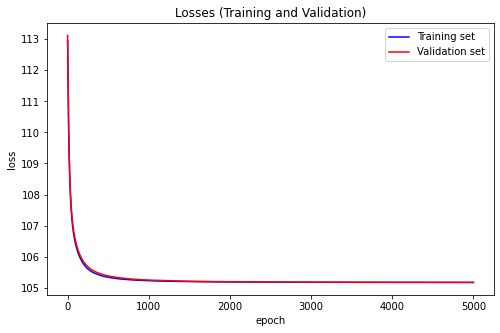

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1,epochs+1), allLossesTrain, 'b', label='Training set')
plt.plot(range(1,epochs+1), allLossesValid, 'r', label='Validation set')
plt.title('Losses (Training and Validation)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Análise do gráfico
Como podemos ver pelo gráfico acima, o modelo parece ter feito um modelo que fez **fit aos dados apropriadamente**, isto é, o erro de Treino diminuiu mas o de validação também, provando assim que não houve overfit ao conjunto de treino. Outro aspeto que se podia revelar neste gráfico seria a **escolha da Learning Rate**. Caso tivesse sido muito alto, iríamos ver muitas oscilações e *jitter* na curva de treino pelo modelo dar sempre passos demasiado grandes e não conseguir convergir apropriadamente para nada. No entanto, como vemos, **a curva é suave** o que demonstra que a Learning Rate usada foi correta.
Olhando para o modelo feito, percebemos que existem muitos parâmetros que podem ser tuned e escolhidos de forma diferente como é o caso da learning rate, de usarmos momentum ou não, do tamanho dos batches, da escolha do optimizer, do número de camadas e neurónios... 

Em deep learning, por ser algo exigente computacionalmente e demorar bastante a treinar um modelo uma vez, **não seria exequível fazermos por exemplo cross-validation** que iria treinar o modelo k vezes para escolher os melhores parâmetros. Assim, neste tipo de problemas a melhor abordagem é mesmo experimentar vários parâmetros e fazer diferentes escolhas para melhorarmos a performance, ressalvando que depois da escolha destes parâmetros, teríamos de testar o nosso modelo com um outro dataset (de treino) que nunca tenha sido visto antes pelo modelo para as previsões não serem enviesadas.

Um aparte é o de ter decidido fazer este gráfico diretamente no *python* ao invés de no TensorBoard pois não era muito intuitiva a maneira de juntar ambas as losses no mesmo gráfico.

## Keras sequencial
O keras dá-nos uma API mais high-level que nos permite criar e fazer operações sobre redes neuronais muito mais facilmente que anteriormente. Durante as aulas falámos de 2 tipos de maneiras de criar um modelo no Keras: sequencialmente e funcionalmente. O **sequencial** é bastante direto e definimos **layer a layer** o que cada uma será. Os passos para criarmos e treinarmos um modelo sequencial do keras serão


1.   Criar a rede em si (layer a layer)
2.   Compilar o modelo
3.   Fazer fit do modelo
4.   Calcular métricas do modelo



Para percebermos como definir a camada de input relativamente ao **número de inputs**, iremos verificar quantos são (por termos de usar este valor na definição da camada com o keras).

In [14]:
X.shape[1]
#Temos 8 atributos

8

## Definir o modelo
Criaremos então agora o modelo!
Este terá 2 camadas **densamente conectadas** (com 4 neurónios) e uma camada de output que retorna um **único valor contínuo** (com 1 neurónio).

In [15]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow import keras

def create_model():
    #se aplicarmos a batch normalization antes do relu, o relu vai po los nao standardizado
    model = Sequential()
    model.add(Dense(4, input_shape = (8,)))
    model.add(Activation("leaky_relu"))
    model.add(BatchNormalization())

    model.add(Dense(4, input_shape = (8,)))
    model.add(Activation("leaky_relu"))
    model.add(BatchNormalization())
    
    model.add(Dense(1))
    return model

## Compilar o modelo
Agora, como dito anteriormente, precisaremos de **compilar o modelo**. Isto é, especificar o tipo de loss function que irá ser utilizada, o tipo de optimizer e algumas métricas que podem ser calculadas para posterior verificação da qualidade do modelo. Os parâmetros e funções usadas (optimizer, loss, learning rate, número de épocas, batch size) serão análogos ao feito no modelo com o tensorflow vanilla.

In [16]:
INIT_LR = 0.001
NUM_EPOCHS = 5000
BS = 128

opt = SGD(lr = INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model = create_model()
model.compile(loss= tf.keras.losses.MeanSquaredError(), optimizer=opt,metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 36        
                                                                 
 activation (Activation)     (None, 4)                 0         
                                                                 
 batch_normalization (BatchN  (None, 4)                16        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 activation_1 (Activation)   (None, 4)                 0         
                                                                 
 batch_normalization_1 (Batc  (None, 4)                16        
 hNormalization)                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## Fit do modelo aos dados
Como dito anteriormente, precisamos agora de fazer o **fit do modelo aos nossos dados** usando a função `fit()` sobre o objecto `model`. Para isto precisamos de passar os nossos dados como argumento (bem como as *labels*) e os restantes parâmetros semelhantes à fase de compilação.

In [17]:
history = model.fit(X, Y, validation_data=(valid_X, valid_Y),
                  batch_size=BS, epochs=NUM_EPOCHS)

A saída de streaming foi truncada nas últimas 5000 linhas.
6/6 [==============================] - 0s 12ms/step - loss: 0.1907 - accuracy: 0.0000e+00 - val_loss: 0.2054 - val_accuracy: 0.0000e+00
Epoch 2502/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.1863 - accuracy: 0.0000e+00 - val_loss: 0.2049 - val_accuracy: 0.0000e+00
Epoch 2503/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.2017 - accuracy: 0.0000e+00 - val_loss: 0.2053 - val_accuracy: 0.0000e+00
Epoch 2504/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.1985 - accuracy: 0.0000e+00 - val_loss: 0.2057 - val_accuracy: 0.0000e+00
Epoch 2505/5000
6/6 [==============================] - 0s 8ms/step - loss: 0.1998 - accuracy: 0.0000e+00 - val_loss: 0.2059 - val_accuracy: 0.0000e+00
Epoch 2506/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.1932 - accuracy: 0.0000e+00 - val_loss: 0.2057 - val_accuracy: 0.0000e+00
Epoch 2507/5000
6/6 [=============================

## Performance do keras sequencial
Faremos agora a avaliação do modelo criado com o keras sequencial.

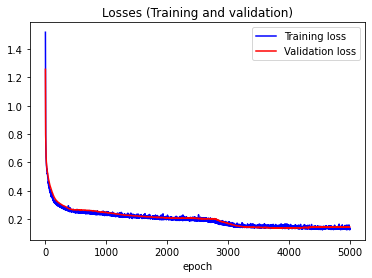

In [18]:
def plot_history(history):
    x = range(1, len(history.history['loss']) + 1)
    trainingLoss = history.history['loss']
    validationLoss = history.history['val_loss']
    plt.plot(x, trainingLoss, 'b', label='Training loss')
    plt.plot(x, validationLoss, 'r', label='Validation loss')
    plt.title('Losses (Training and validation)')
    plt.xlabel('epoch')
    plt.legend()
    
plot_history(history)

Como podemos ver pelo gráfico acima, **não houve overfit** por parte do modelo pela mesma explicação que no implementado com o tensorflow. Embora pareca que a curva de treino está jittery, mas no primeiro modelo tal não aconteceu. Ora, voltando a verificar qual fora o valor usado, percebemos que foi de 0.0001 (uma dimensão a menos que a que agora), e por isso explica a **ligeira quantidade de jitter** que desapareceria caso alterássemos para o mesmo valor.

In [19]:
loss, acc = model.evaluate(valid_X, valid_Y)
print('Validation Loss: ' +str(loss))

11/11 [==============================] - 0s 2ms/step - loss: 0.1446 - accuracy: 0.0000e+00
Validation Loss: 0.14463722705841064


## Keras funcional
Passemos agora do keras sequencial para o keras funcional. As vantagens deste comparativamente ao sequencial é o de podermos **criar modelos mais complexos** que não são possíveis com o outro. Como exemplo de rede complexa é uma que tenha camadas partilhadas e que possa **fugir à regra de uma camada apenas se poder conectar com a ultima camada**.

## Definir o modelo
Definiremos de seguida então a topologia da rede. Esta será muito semelhante à anterior mas usando o keras funcional.

In [20]:
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, Dense
from tensorflow.keras.layers import MaxPooling2D, Activation, Flatten, Dropout

inputs = Input(shape=(8, ),name='inputs')
layer = Dense(4)(inputs)
layer = Activation(LeakyReLU())(layer)
layer = BatchNormalization(axis=-1)(layer)
####
layer = Dense(4)(layer)
layer = Activation(LeakyReLU())(layer)
layer = BatchNormalization(axis=-1)(layer)
#####
layer = Dense(1)(layer)

O nosso modelo terá como inputs o que nós passamos (que serão os dados com os 8 atributos iguais a anteriormente) e como output o final da ultima layer.

In [21]:
functionalKerasModel = Model(inputs = inputs, outputs = layer)   
functionalKerasModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 8)]               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 activation_2 (Activation)   (None, 4)                 0         
                                                                 
 batch_normalization_2 (Batc  (None, 4)                16        
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 4)                 20        
                                                                 
 activation_3 (Activation)   (None, 4)                 0         
                                                             

## Compilar o modelo e fazer o fit
Assim como no sequencial, agora precisaremos de **compilar** o nosso modelo e posteriormente fazer o **fit** ao mesmo com os nossos dados.

In [22]:
NUM_EPOCHS = 5000
BS= 128
opt = SGD(lr=0.00001, momentum=0.9)

functionalKerasModel.compile(loss=tf.keras.losses.MeanSquaredError(),optimizer=opt, metrics=["accuracy"])
functionalKerasModel.summary()
fittedModel = functionalKerasModel.fit(X, Y,validation_data=(valid_X, valid_Y),batch_size=BS, epochs=NUM_EPOCHS)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 8)]               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 activation_2 (Activation)   (None, 4)                 0         
                                                                 
 batch_normalization_2 (Batc  (None, 4)                16        
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 4)                 20        
                                                                 
 activation_3 (Activation)   (None, 4)                 0         
                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


A saída de streaming foi truncada nas últimas 5000 linhas.
6/6 [==============================] - 0s 10ms/step - loss: 0.3618 - accuracy: 0.0000e+00 - val_loss: 0.3982 - val_accuracy: 0.0000e+00
Epoch 2502/5000
6/6 [==============================] - 0s 9ms/step - loss: 0.3886 - accuracy: 0.0000e+00 - val_loss: 0.3982 - val_accuracy: 0.0000e+00
Epoch 2503/5000
6/6 [==============================] - 0s 8ms/step - loss: 0.3655 - accuracy: 0.0000e+00 - val_loss: 0.3982 - val_accuracy: 0.0000e+00
Epoch 2504/5000
6/6 [==============================] - 0s 8ms/step - loss: 0.3679 - accuracy: 0.0000e+00 - val_loss: 0.3981 - val_accuracy: 0.0000e+00
Epoch 2505/5000
6/6 [==============================] - 0s 8ms/step - loss: 0.3690 - accuracy: 0.0000e+00 - val_loss: 0.3981 - val_accuracy: 0.0000e+00
Epoch 2506/5000
6/6 [==============================] - 0s 8ms/step - loss: 0.3648 - accuracy: 0.0000e+00 - val_loss: 0.3981 - val_accuracy: 0.0000e+00
Epoch 2507/5000
6/6 [=============================

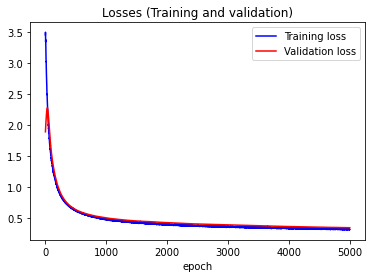

In [23]:
plot_history(fittedModel)

## Análise da performance 
Como esperado, o resultado foi muito semelhante aos anteriores por apenas mudarmos de sequencial para funcional, não alterando a estrutura da rede. 

## Conclusão
Neste tutorial foram usadas 3 diferentes metodologias de criar o mesmo modelo, implementando redes neuronais para resolver o problema de prever a força do cimento dados 8 atributos relativamente à sua constituição. Relativamente ao tensorflow sem APIs high-level, este foi bom para perceber como as coisas funcionam a um nível mais detalhado mas por questões de praticalidade, ambos os modelos do Keras oferecem muito mais. Outro aspeto importante de reiterar é a questão da seleção dos hiperparâmetros, cujas alternativas poderiam ser exploradas para melhorar ainda mais os modelos desenvolvidos.